# Time Series in Python
# Practical approach

Автор: Сергеев Дмитрий

https://github.com/DmitrySerg

## План
1. Введение
  * Основные определения, варианты постановки задачи
  * Метрики качества прогнозов, R^2, MSE, MAE, MAPE и т.д.
2. Движемся, сглаживаем и оцениваем 
  * Rolling window estimations + практика, прогнозируем оконными функциями, считаем качество
  * Holt-Winters
  * Кросс-валидация на временных рядах, подбор параметров + практика, оценка Holt-Winters с минимизацией ошибки на кросс-валидации на разных рядах
3. Эконометрический подход 
  * Стационарность и единичные корни - интуиция теории + практика проверки разных рядов на стационарность, ADF
  * Избавление от нестационарности, дифференцирование, сезонное дифференцирование, выделение трендов + практика, приводим ряд к стационарному виду
  * ARIMA, немного интуиции, выбор начальных параметров модели по ACF, PACF, выбор параметров перебором, построение SARIMAX с подобранными параметрами
  * Ограничения, недостатки эконометрического подхода
4. Machine Learning для временных рядов 
  * Feature extraction, engineering, предобработка данных, какие признаки и как можно извлечь + практика, формируем датасет для моделей по ряду, пишем функцию для автогенерации признаков
  * Линейные модели, обучаем, смотрим качество на кросс-валидации, оцениваем важность признаков
  * Регуляризация, отбор признаков, сокращение признакового пространства, ridge, lasso
  * Бустиг для временных рядов - ограничения и преимущества
5. To Infinity and Beyond 
  * Facebook Prophet - автоматические прогнозы
  * Что еще можно делать с временными рядами - RNN, LSTM 

In [1]:
import numpy as np                               # работа с векторами и матрицами
import pandas as pd                              # таблицы и операции над данными
import matplotlib.pyplot as plt                  # графики
import seaborn as sns                            # еще графики

from dateutil.relativedelta import relativedelta # для комфортной работы с датами
from scipy.optimize import minimize              # позволяет минимизировать функции

import statsmodels.formula.api as smf            # всякая статистика и эконометрика
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # немножко функций для удобства
from tqdm import tqdm_notebook

import warnings                                  # чтобы никто не мешал бесчинствам с кодом
warnings.filterwarnings('ignore')

%matplotlib inline

/Users/dmitrys/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 1) Введение

На работе я практически ежедневно сталкиваюсь с теми или иными задачами, связанными с временными рядам. Чаще всего возникает вопрос — а что у нас будет происходить с нашими показателями в ближайший день/неделю/месяц/пр. — сколько игроков установят приложения, сколько будет онлайна, как много действий совершат пользователи, и так далее. К задаче прогнозирования можно подходить по-разному, в зависимости от того, какого качества должен быть проноз, на какой период мы хотим его строить, и, конечно, как долго нужно подбирать и настраивать параметры модели для его получения.

Небольшое [определение](https://ru.wikipedia.org/wiki/Временной_ряд) временного ряда:
> Временной ряд – это последовательность значений, описывающих протекающий во времени процесс, измеренных в последовательные моменты времени, обычно через равные промежутки

Таким образом, данные оказываются упорядочены относительно неслучайных моментов времени, и, значит, в отличие от случайных выборок, могут содержать в себе дополнительную информацию, которую мы постараемся извлечь. 

В целом, задачи, связанные с временными рядами можно разбить на несколько групп
- Прогнозирование - когда хотим узнать, что будет дальше
- Поиск аномалий - когда хотим понять, где были проблемы в прошлом
- Кластеризация и классификация - когда временные ряды сами являются признаками объектов

C какими временными рядами будем работать


In [2]:
ads = pd.read_csv('data/ads.csv', index_col=['Time'], parse_dates=['Time'])
currency = pd.read_csv('data/currency.csv', index_col=['Time'], parse_dates=['Time'])

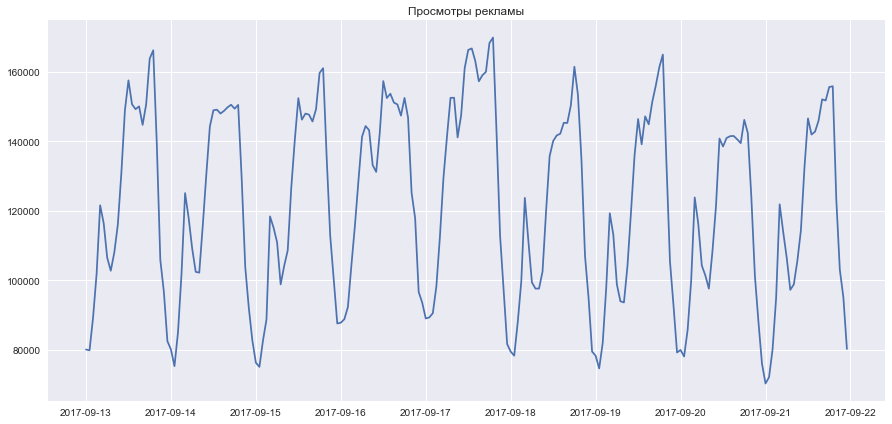

In [3]:
plt.figure(figsize=(15, 7))
plt.plot(ads.Ads)
plt.title('Просмотры рекламы')
plt.grid(True)
plt.show()

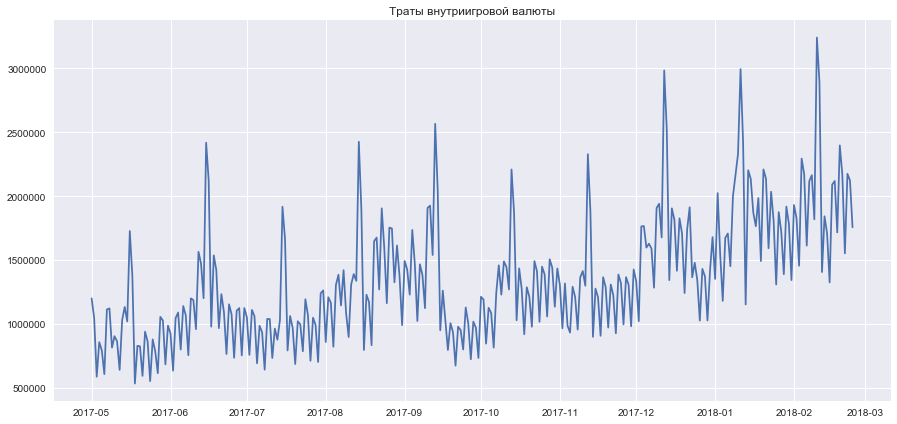

In [4]:
plt.figure(figsize=(15, 7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('Траты внутриигровой валюты')
plt.grid(True)
plt.show()

## Метрики качества прогноза

Рассмотрим основные и самые распространенные метрики качества прогнозов, которые, по большому счету, являются метриками для задачи регрессии и используются далеко не только во временных рядах.

- [R squared](http://scikit-learn.org/stable/modules/model_evaluation.html#r2-score-the-coefficient-of-determination), коэффициент детерминации (в эконометрике - доля объясненной моделью дисперсии), $(-\infty, 1]$

$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$ 

```python
sklearn.metrics.r2_score
```
---
- [Mean Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error), интерпретируемая метрика, измеряется в тех же единицах, что и исходный ряд, $[0, +\infty)$

$MAE = \frac{\sum\limits_{i=1}^{n} |y_i - \hat{y}_i|}{n}$ 

```python
sklearn.metrics.mean_absolute_error
```
---
- [Median Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#median-absolute-error), также интерпретируемая метрика, однако её преимущество - нечувствительность (робастность) к выбросам в данных, $[0, +\infty)$

$MedAE = median(|y_1 - \hat{y}_1|, ... , |y_n - \hat{y}_n|)$

```python
sklearn.metrics.median_absolute_error
```
---
- [Mean Squared Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error), используется в большинстве случаев, сильнее наказывает модель за большие ошибки и меньше - за маленькие (парабола), $[0, +\infty)$

$MSE = \frac{1}{n}\sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2$

```python
sklearn.metrics.mean_squared_error
```
---
- [Mean Squared Logarithmic Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-logarithmic-error), практически тоже самое, но значения предварительно логарифмируются, таким образом маленьким ошибкам также уделяется значительное внимание, обычно используется, если данным присущ экспоненциальный рост, $[0, +\infty)$

$MSLE = \frac{1}{n}\sum\limits_{i=1}^{n} (log(1+y_i) - log(1+\hat{y}_i))^2$

```python
sklearn.metrics.mean_squared_log_error
```
---
- Mean Absolute Percentage Error, как MAE, только в процентах, - удобно для объяснения заказчику качества прогноза, $[0, +\infty)$

$MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$ 

```python
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
```

In [5]:
# импортируем всё, о чем говорили выше

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Отлично, теперь мы знаем, как можно измерить качество нашего прогноза, какие метрики стоит применять и как объяснить содеянное заказчику, дело осталось за малым - нужно построить прогноз

# 2) Движемся, сглаживаем и оцениваем

## Rolling window estimations

Начнем моделирование с наивного предположения - "завтра будет, как вчера", но вместо модели вида $\hat{y}_{t} = y_{t-1}$ будем считать, что будущее значение переменной зависит от среднего $n$ её предыдущих значений, а значит, воспользуемся скользящей средней. 

$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k-1}_{n=0} y_{t-n}$

In [6]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

In [7]:
moving_average(ads, 6)

118911.66666666667

К сожалению, такой прогноз долгосрочным сделать не удастся, для получения предсказания на шаг вперед предыдущее значение должно быть фактически наблюдаемой величиной. Зато у скользящей средней есть другое применение - сглаживание исходного ряда для выявления трендов, в пандасе есть готовая реализация - [`DataFrame.rolling(window).mean()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html). Чем больше зададим ширину интервала - тем более сглаженным окажется тренд. В случае, если данные сильно зашумлены, что особенно часто встречается, например, в финансовых показателях, такая процедура может помочь увидеть общие паттерны.

Применим такое сглаживание к нашим рядам

In [8]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # При желании, можно строить и доверительные интервалы для сглаженных значений
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # а имея доверительные интервалы, можно искать аномальные значения
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

Сглаживание по последним 4 часам

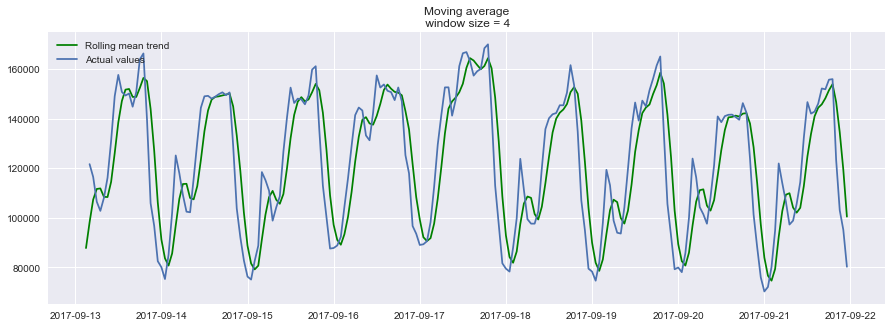

In [9]:
plotMovingAverage(ads, 4)

По 12 часам (полдня)

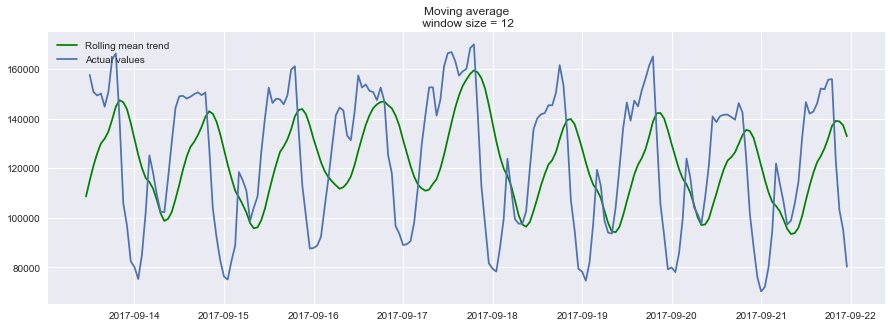

In [10]:
plotMovingAverage(ads, 12)

Сглаживание по 24 часам (одни сутки) - выделяется дневной тренд

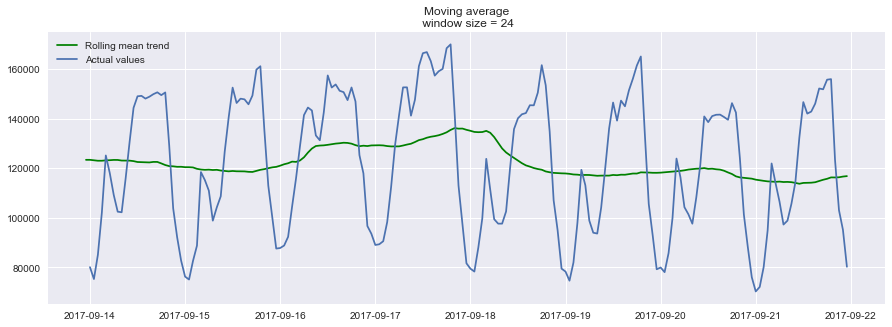

In [11]:
plotMovingAverage(ads, 24)

Также можно отобразить доверительные интервалы для наших средних значений

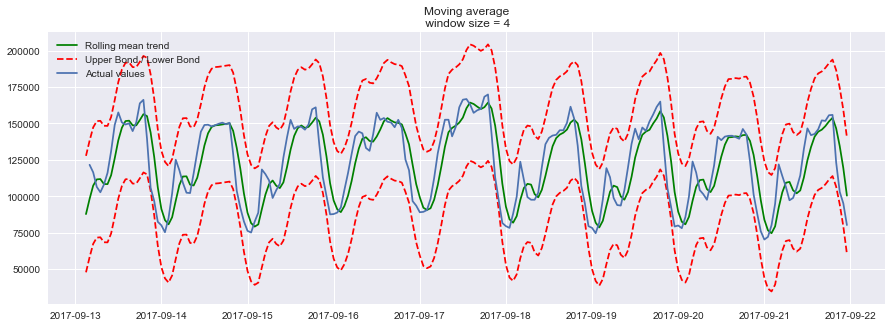

In [12]:
plotMovingAverage(ads, 4, plot_intervals=True)

А теперь попробуем при помощи этих доверительных интервалов поймать аномалию во временном ряде. К сожалению или к счастью, конкретно в этом ряду всё более-менее хорошо и гладко, поэтому аномальное значение мы зададим самостоятельно в датафрейме `ads_anomaly`

In [13]:
ads_anomaly = ads.copy()
ads_anomaly.iloc[-20] = ads_anomaly.iloc[-20] * 0.2 # падение показателя на 80% 

И посмотрим, удастся ли таким простым образом её поймать

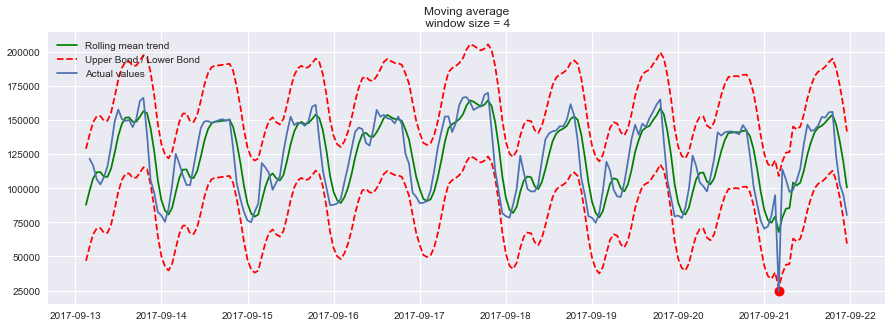

In [14]:
plotMovingAverage(ads_anomaly, 4, plot_intervals=True, plot_anomalies=True)

Тоже самое можно проделать и со вторым рядом, попробуем сгладить его с окном в 7 дней, то есть по неделям, и поймать аномалии

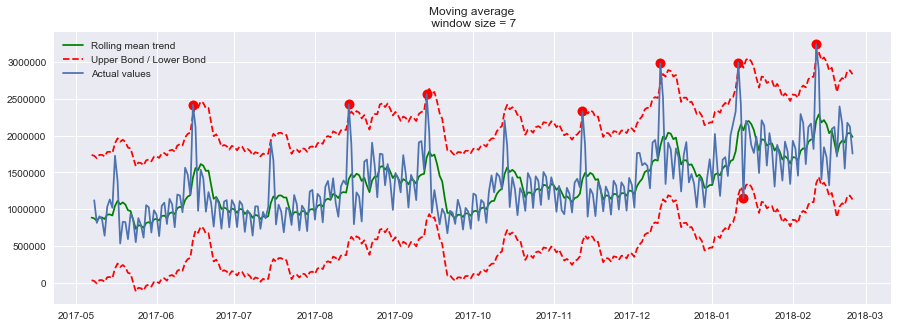

In [15]:
plotMovingAverage(currency, 7, plot_intervals=True, plot_anomalies=True)

## Тройное экспоненциальное сглаживание a.k.a. Holt-Winters

Основная идея модели - разложение ряда на три составляющие: уровень (level, intercept), тренд (trend, slope) и сезонную компоненту. Уровень показывает, вокруг какого значения сосредоточены значения временного ряда, тренд - направление движения значений, а сезонность объясняет повторяющиеся колебания вокруг уровня и тренда.

Вместо взвешивания последних $n$ значений ряда мы начнем взвешивать все доступные наблюдения, при этом экспоненциально уменьшая веса по мере углубления в исторические данные. И каждая из компонент будет взвешиваться отдельно, при помощи своего сглаживающего параметра. 

Сезонность будет характеризоваться длиной сезона - периодом, после которого начинаются повторения колебаний. Для каждого наблюдения в сезоне формируется своя компонента, например, если длина сезона составляет 7 (например, недельная сезонность), то получим 7 сезонных компонент, по штуке на каждый из дней недели.

Получаем систему:

$$\ell_x = \alpha(y_x - s_{x-L}) + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

$$s_x = \gamma(y_x - \ell_x) + (1-\gamma)s_{x-L}$$

$$\hat{y}_{x+m} = \ell_x + mb_x + s_{x-L+1+(m-1)modL}$$

Уровень $\ell_x$ зависит от текущего значения ряда за вычетом соответствующей сезонной компоненты, для тренда $b_x$ предполагаем, что что будущее направление изменения ряда зависит от взвешенных предыдущих изменений, а сезонная компонента $s_x$ зависит от текущего значения ряда за вычетом уровня и от предыдущего значения компоненты. При этом компоненты сглаживаются через все доступные сезоны, например, если это компонента, отвечающая за понедельник, от и усредняться она будет только с другими понедельниками. Подробнее про работу усреднений и оценку начальных значений тренда и сезонных компонент можно почитать [здесь](http://www.itl.nist.gov/div898/handbook/pmc/section4/pmc435.htm). 

Ниже импортируем класс для построения модели тройного экспоненциального сглаживания, также известного по фамилиям её создателей - Чарльза Хольта и его студента Питера Винтерса. 
Дополнительно в модель включен метод Брутлага для построения доверительных интервалов:

$$\hat y_{max_x}=\ell_{x−1}+b_{x−1}+s_{x−T}+m⋅d_{t−T}$$

$$\hat y_{min_x}=\ell_{x−1}+b_{x−1}+s_{x−T}-m⋅d_{t−T}$$

$$d_t=\gamma∣y_t−\hat y_t∣+(1−\gamma)d_{t−T}$$

где $T$ - длина сезона, $d$ - предсказанное отклонение, а остальные параметры берутся из тройного сглаживани. Подробнее о методе и о его применении к поиску аномалий во временных рядах можно прочесть [здесь](https://fedcsis.org/proceedings/2012/pliks/118.pdf)

## Кросс-валидация на временных рядах

Перед тем, как построить модель, поговорим о не ручной оценке параметров для моделей. 

Ничего необычного здесь нет, по-прежнему сначала необходимо выбрать подходящуюю для данной задачи функцию потерь, которая будет следить за качеством подгонки модели под исходные данные. Затем будем оценивать на кросс-валидации значение функции потерь при данных параметрах модели, искать градиент, менять в соответствии с ним параметры и бодро опускаться в сторону глобального минимума ошибки. 

Так как временной ряд внезапно имеет временную структуру, случайно перемешивать в фолдах значения всего ряда без сохранения этой структуры нельзя, иначе в процессе потеряются все взаимосвязи наблюдений друг с другом. Поэтому придется использовать чуть более хитрый способ для оптимизации параметров, официального названия которому я так и не нашел, но на сайте [CrossValidated](https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection), предлагают название "cross-validation on a rolling basis", что не дословно можно перевести как кросс-валидация на скользящем окне.

Суть достаточно проста - начинаем обучать модель на небольшом отрезке временного ряда, от начала до некоторого $t$, делаем прогноз на $t+n$ шагов вперед и считаем ошибку. Далее расширяем обучающую выборку до $t+n$ значения и прогнозируем с $t+n$ до $t+2*n$, так продолжаем двигать тестовый отрезок ряда до тех пор, пока не упрёмся в последнее доступное наблюдение. В итоге получим столько фолдов, сколько $n$ уместится в промежуток между изначальным обучающим отрезком и всей длиной ряда.

<img src="https://habrastorage.org/files/f5c/7cd/b39/f5c7cdb39ccd4ba68378ca232d20d864.png"/>

Теперь, зная, как настраивать кросс-валидацию, подберём с её помощью параметры для модели Хольта-Винтерса

In [16]:
from sklearn.model_selection import TimeSeriesSplit # здорово, когда всё реализовано до тебя
from HoltWinters import HoltWinters                 # код большой, поэтому лежит отдельно

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # вектор ошибок
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [17]:
%%time
data = ads.Ads[:-20] # отложим часть данных для тестирования

# инициализируем значения параметров
x = [0, 0, 0] 

# Минимизируем функцию потерь с ограничениями на параметры
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_log_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# и подставляем их в модель
model = HoltWinters(data, slen = 24, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)
model.triple_exponential_smoothing()

0.11652680227350454 0.002677697431105852 0.05820973606789237
CPU times: user 2.16 s, sys: 28.6 ms, total: 2.19 s
Wall time: 2.3 s


In [18]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

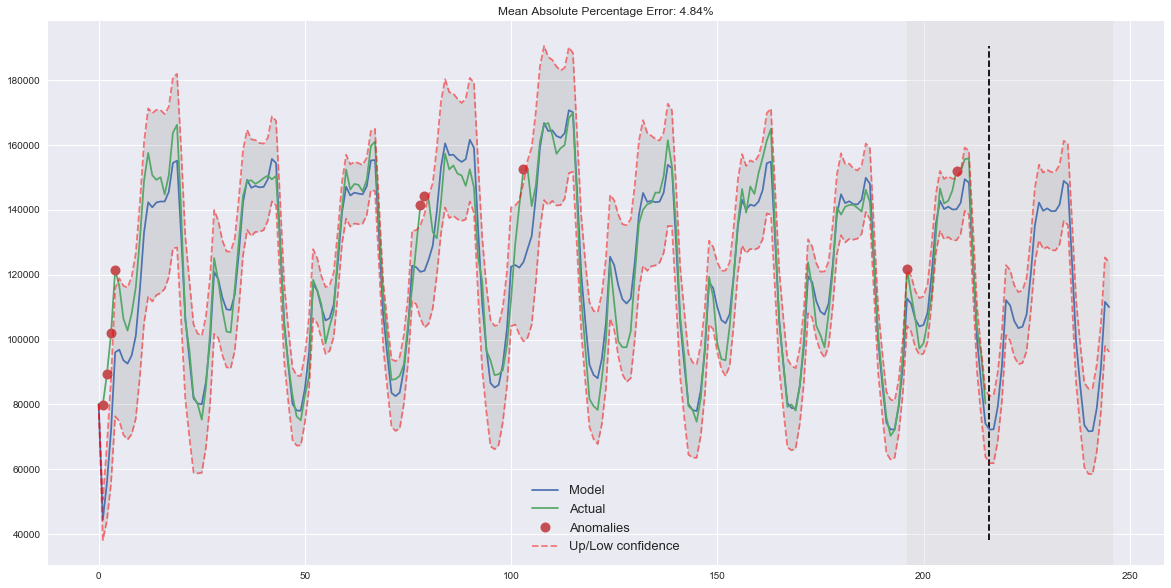

In [19]:
plotHoltWinters(ads.Ads, plot_intervals=True, plot_anomalies=True)

Если посмотреть на смоделированное отклонение, хорошо видно, что модель достаточно резко регирует на значительные изменения в структуре ряда, но при этом быстро возвращает дисперсию к обычным значениям, "забывая" прошлое. Такая особенность позволяет неплохо и без значительных затрат на подготовку-обучение модели настроить систему по детектированию аномалий даже в достаточно шумных рядах.

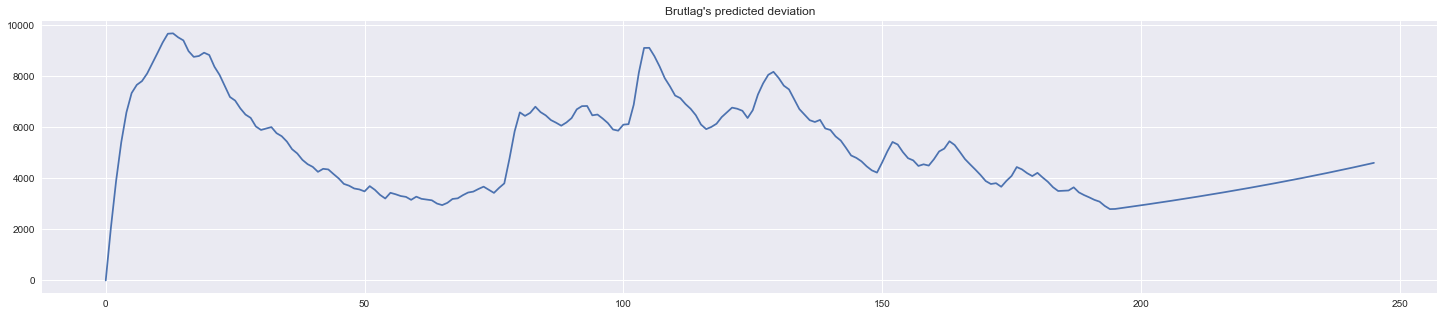

In [20]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

Прогоним тот же самый алгоритм для второго временного ряда, в котором, как мы знаем, есть тренд и месячная сезонность

In [21]:
%%time
data = currency.GEMS_GEMS_SPENT[:-50] # отложим часть данных для тестирования
slen = 30 # месячная сезонность
# инициализируем значения параметров
x = [0, 0, 0] 

# Минимизируем функцию потерь с ограничениями на параметры
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_absolute_percentage_error, slen), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)


model = HoltWinters(data, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 100, scaling_factor = 3)
model.triple_exponential_smoothing()

0.012841445048055122 0.04883371471892228 0.00943678056045777
CPU times: user 3.38 s, sys: 63.9 ms, total: 3.45 s
Wall time: 3.66 s


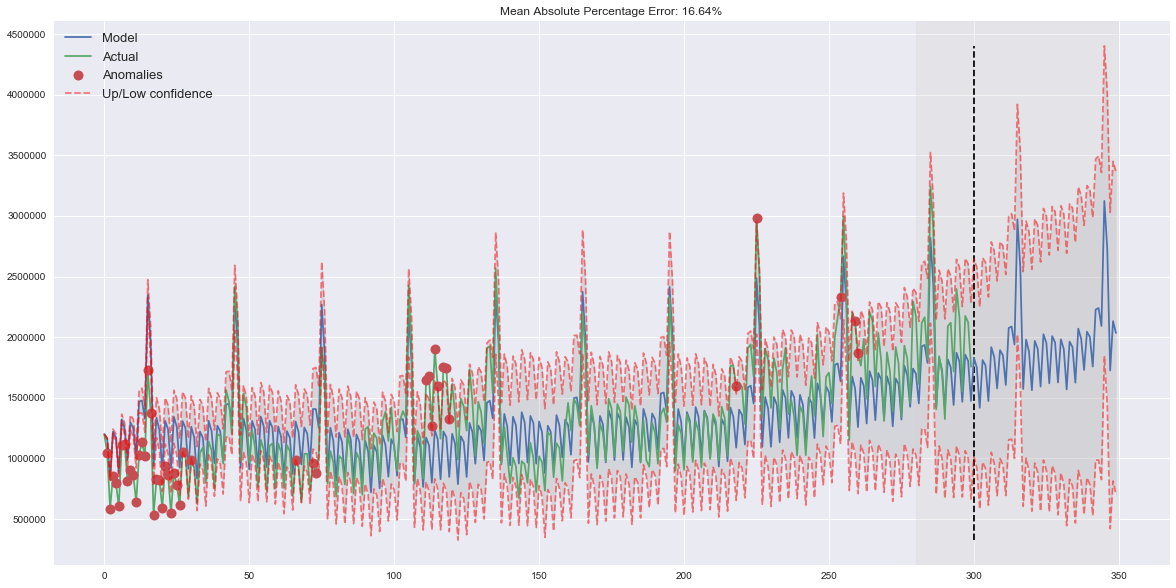

In [22]:
plotHoltWinters(currency.GEMS_GEMS_SPENT, plot_intervals=True, plot_anomalies=True)

Выглядит весьма правдоподобно, модель уловила и восходящий тренд, и сезонные пики, и в целом достаточно точно описывает наш временной ряд

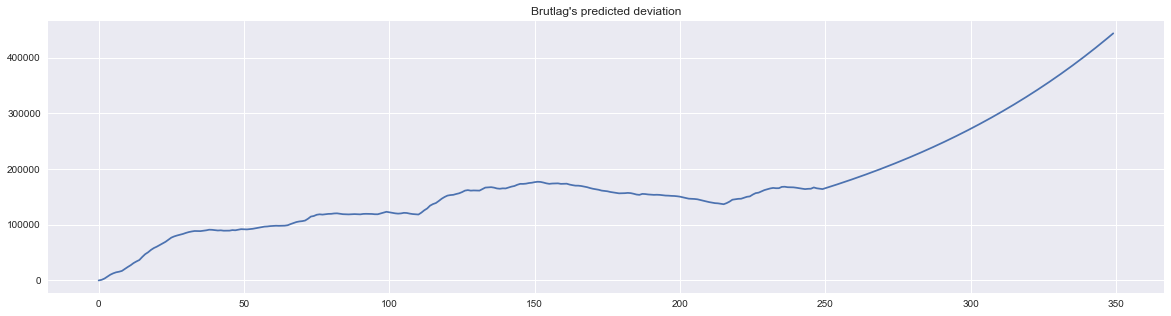

In [23]:
plt.figure(figsize=(20, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

# 3) Эконометрический подход

### Стационарность

Перед тем, как перейти к моделированию, стоит сказать о таком важном свойстве временного ряда, как [**стационарность**](https://ru.wikipedia.org/wiki/Стационарность). 
Под стационарностью понимают свойство процесса не менять своих статистических характеристик с течением времени, а именно постоянство матожидания, постоянство дисперсии (она же [гомоскедастичность](https://ru.wikipedia.org/wiki/Гомоскедастичность)) и независимость ковариационной функции от времени (должна зависеть только от расстояния между наблюдениями). Наглядно можно посмотреть на эти свойства на картинках, взятых из поста [Sean Abu](http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/):

- Временной ряд справа не является стационарным, так как его матожидание со временем растёт

<img src="https://habrastorage.org/files/20c/9d8/a63/20c9d8a633ec436f91dccd4aedcc6940.png"/>

- Здесь не повезло с дисперсией - разброс значений ряда существенно варьируется в зависимости от периода

<img src="https://habrastorage.org/files/b88/eec/a67/b88eeca676d642449cab135273fd5a95.png"/>

- Наконец, на последнем графике видно, что значения ряда внезапно становятся ближе друг ко другу, образуя некоторый кластер, а в результате получаем непостоянство ковариаций

<img src="https://habrastorage.org/files/2f6/1ee/cb2/2f61eecb20714352840748b826e38680.png"/>

Почему стационарность так важна? По стационарному ряду просто строить прогноз, так как мы полагаем, что его будущие статистические характеристики не будут отличаться от наблюдаемых текущих. Большинство моделей временных рядов так или иначе моделируют и предсказывают эти характеристики (например, матожидание или дисперсию), поэтому в случае нестационарности исходного ряда предсказания окажутся неверными. К сожалению, большинство временных рядов, с которыми приходится сталкиваться за пределыми учебных материалов, стационарными не являются, но с этим можно (и нужно) бороться.

## Избавляемся от нестационарности и строим SARIMA

Попробуем теперь построить SARIMA модель, пройдя все ~~круги ада~~ стадии приведения ряда к стационарному виду. Подробно про саму модель можно почитать здесь - [Построение модели SARIMA с помощью Python+R](https://habrahabr.ru/post/210530/), [Анализ временных рядов с помощью python](https://habrahabr.ru/post/207160/)

In [24]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])
        plt.tight_layout()

Критерий Дики-Фуллера: p=0.000000


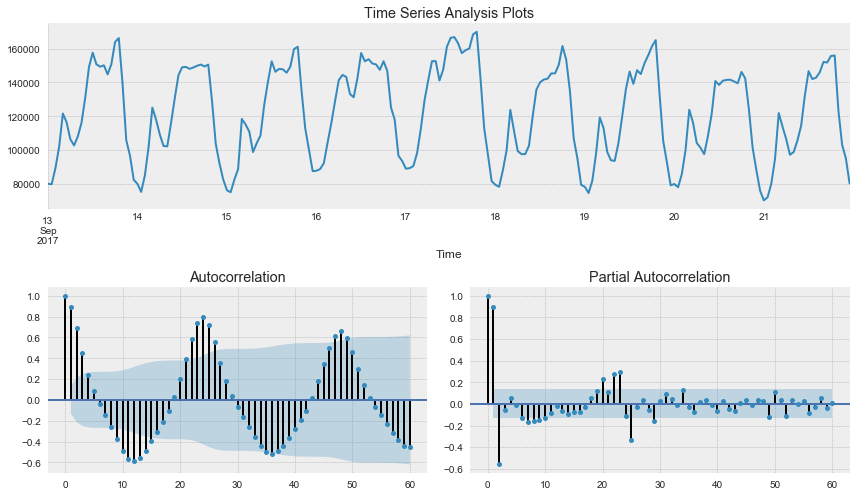

In [25]:
tsplot(ads.Ads, lags=60)

Отлично, этот ряд по критерию Дикки-Фуллера у нас стационарен, по его графику тоже видно, что тренд, как таковой, отсутствует, т.е., матожидание постоянно, разброс вокруг среднего тоже примерно одинаковый, значит, постоянство дисперсии также наблюдается. Остаётся сезонность, с которой нужно разобраться перед построением модели.
Для этого выполним преобразование под хитрым названием "сезонное дифференцирование", под которым скрывается простое вычитание из ряда самого себя с лагом равным периоду сезонности.

Критерий Дики-Фуллера: p=0.047417


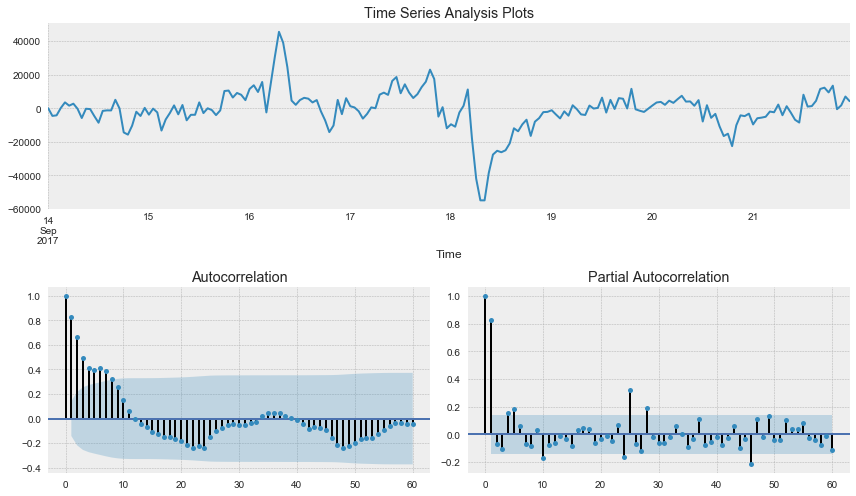

In [26]:
ads_diff = ads.Ads - ads.Ads.shift(24)
tsplot(ads_diff[24:], lags=60)

Уже лучше, от видимой сезонности избавились, в автокорреляционной функции по-прежнему осталось много значимых лагов, попробуем от них избавиться, взяв еще и первые разности - то есть вычитание ряда самого из себя с лагом в один шаг

Критерий Дики-Фуллера: p=0.000000


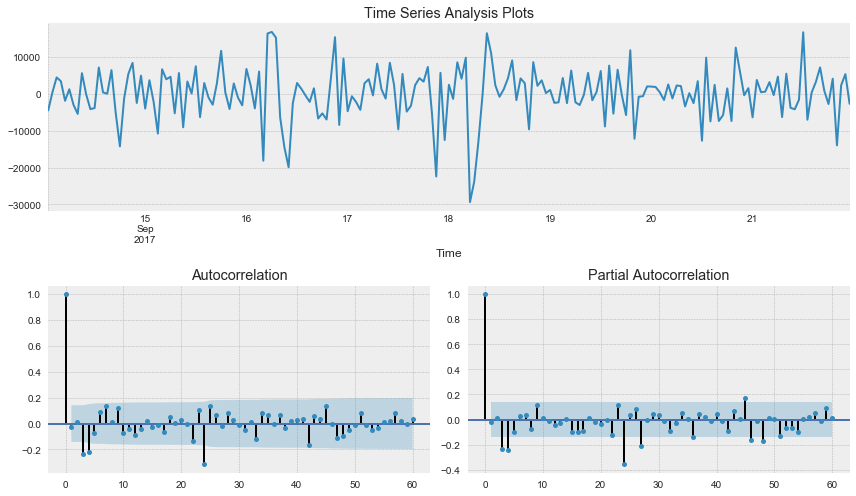

In [27]:
ads_diff = ads_diff - ads_diff.shift(1)
tsplot(ads_diff[24+1:], lags=60)

Отлично, теперь ряд выглядит как непонятно что, колеблющееся вокруг нуля, по критерию Дикки-Фуллера он стационарен, а в автокорреляционной функции пропали многочисленные значимые пики. Можно приступать к моделированию! 

## Экспресс-введение в ARIMA-семейство

Cовсем вкратце о самой модели. Начнём по буквам составлять это длинное название $SARIMA(p, d, q)(P, D, Q, s)$, Seasonal Autoregression Moving Average model:

- $AR(p)$ - модель авторегрессии, т.е. регрессии временного ряда на самого себя, в основе лежит предположение о том, что временной ряд зависит от своих предыдущих значений с некоторым лагом (или с несколькими лагами), максимальный лаг, который входит в модель, обозначается буквой $p$. Определить начальное значение $p$ можно при помощи графика PACF по значимому лагу, после которого большинство оставшихся лагов становятся не значимыми.
- $MA(q)$ - модель скользящего среднего, если не вдаваться в детали - моделирует случайные ошибки временного ряда, т.е., как текущая ошибка во временном ряду зависит от предыдущих с некоторым лагом, здесь лаг обозначается буквой $q$. Начальное значение можно определить по графику ACF, логика аналогична.

Немножко остановимся и объединим первые четыре буквы, чтобы посмотреть, что у нас получилось:

$AR(p) + MA(q) = ARMA(p, q)$

А у нас получилась модель авторегрессии - скользящего среднего, если временной ряд стационарен, его можно смело аппроксимировать этими четырьмя буквами. Продолжим-с

- $I(d)$ - порядок интегрированности временного ряда. За этими словами стоит очень простая штука - сколько нам обычных разностей в ряде пришлось взять, чтобы привести его к стационарному, такой порядок интегрированности и будет. В нашем случае это единичка, так как мы взяли от нашего ряда первую разность. 

Добавим к нашим четырём буквам и получим модель $ARIMA$, которая умеет работать с нестационарными временными рядами, которые можно привести к стационарным при помощи взятия разностей некоторого порядка. Отлично, осталась последняя буква!

- $S(s)$ - эта буква отвечает за сезонность и равна длине периода сезонности во временном ряде

Прикрепляем последнюю букву и оказывается, что вместо одного дополнительного параметра у нас добавилось сразу три - $(P, D, Q)$

- $P$ - порядок модели авторегрессии для сезонной компоненты, также определяется по PACF, только смотреть нужно на число значимых лагов, кратных периоду сезонности, например, если период равен 24 и выясняется, что по PACF значим 24-й и 48-й лаг, то для начального приближения можно взять $P = 2$

- $Q$ - аналогично, но для модели скользящего среднего по сезонной компоненте, определяется по ACF

- $D$ - порядок сезонной интегрированности временного ряда. Может быть равен либо 0, либо 1, так как сезонное дифференцирование либо проводилось, либо нет

Теперь мы знаем, как подбирать параметры, еще раз посмотрим на график получившегося после преобразований стационарного ряда и попробуем подобрать начальные приближения параметров:

Критерий Дики-Фуллера: p=0.000000


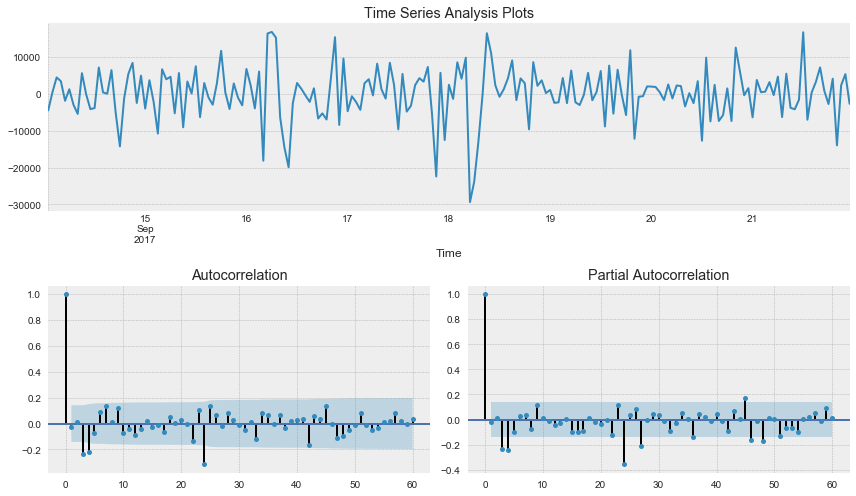

In [28]:
tsplot(ads_diff[24+1:], lags=60)

In [29]:
# зададим ограничения на возможные значения параметров для перебора
ps = range(2, 5)
d=1 # тут мы уверены, дифференцировали один раз
qs = range(2, 5)

Ps = range(0, 2)
D=1 # здесь тоже уверены, сезонное дифференцирование было одно
Qs = range(0, 2)
s = 24

# создадим лист с возможными параметрами и посчитаем его длину
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [30]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # try except нужен, потому что на некоторых наборах параметров модель не обучается
        try:
            model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[3], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        #сохраняем лучшую модель, aic, параметры
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # сортируем по возрастанию, чем меньше критерий AIC, тем лучше
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [31]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

Widget Javascript not detected.  It may not be installed or enabled properly.



CPU times: user 31.8 s, sys: 2.5 s, total: 34.3 s
Wall time: 30.4 s


In [32]:
result_table.head()

,parameters,aic
0,"(4, 2, 0, 1)",3890.279587
1,"(4, 2, 1, 1)",3890.279587
2,"(4, 2, 0, 0)",3927.568419
3,"(4, 2, 1, 0)",3927.568419
4,"(2, 2, 0, 0)",NaN


In [33]:
# передаём параметры с минимальным AIC
p, q, P, Q = result_table.parameters[0]

In [34]:
# обучаем лучшую модель
best_model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)

In [35]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                Ads   No. Observations:                  216
Model:             SARIMAX(4, 1, 2)x(0, 1, 1, 24)   Log Likelihood               -1941.537
Date:                            Mon, 26 Mar 2018   AIC                           3899.074
Time:                                    20:28:17   BIC                           3926.076
Sample:                                09-13-2017   HQIC                          3909.983
                                     - 09-21-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3135      0.650      0.482      0.630      -0.960       1.587
ar.L2         -0.2554      0.436   

Критерий Дики-Фуллера: p=0.000000


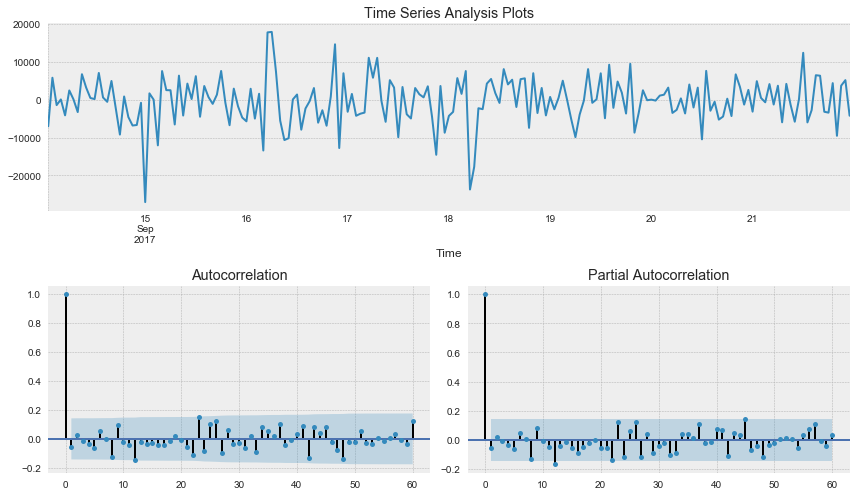

In [36]:
tsplot(best_model.resid[24+1:], lags=60)

Что ж, остатки стационарны, явных автокорреляций нет, построим прогноз по получившейся модели

In [37]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # подставляем модельные значения
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # делаем отступ на s+d, так как эти значения в модели были ненаблюдаемыми
    # из-за дифференцирования
    data['arima_model'][:s+d] = np.NaN
    
    # прогнозируем на n_steps шагов вперёд 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # считаем ошибку, также отступив s+d шагов от начала
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

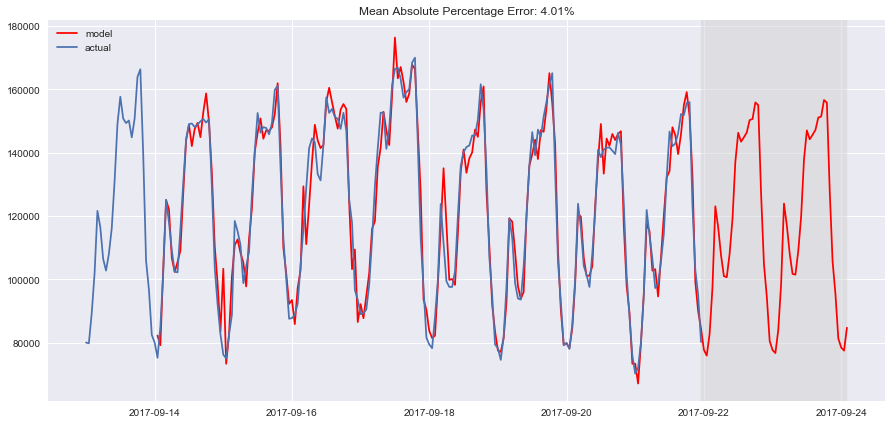

In [38]:
plotSARIMA(ads, best_model, 50)

В финале получаем очень хороший прогноз, заказчику средняя абсолютная ошибка в 4 процента также наверняка понравится, однако суммарные затраты на подготовку данных, приведение к стационарности, определение и перебор параметров могут такой точности и не стоить.

# 4) Machine Learning для временных рядов

### Временные ряды без правил или прогнозируем, чем можем

Снова небольшое лирическое отступление. Часто на работе приходится строить модели, руководствуясь одним основополагающим принципом – [быстро, качественно, недорого](http://lurkmore.to/%D0%91%D1%8B%D1%81%D1%82%D1%80%D0%BE,_%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B5%D0%BD%D0%BD%D0%BE,_%D0%BD%D0%B5%D0%B4%D0%BE%D1%80%D0%BE%D0%B3%D0%BE). Поэтому часть моделей могут банально не подойти для "продакшн-решений", так как либо требуют слишком больших затрат по подготовке данных, либо сложно настраиваются, либо требуют частого переобучения на новых данных, поэтому зачастую гораздо проще бывает выделить несколько признаков из имеющегося временного ряда и построить по ним обычную линейную регрессию или навесить решаюший лес. Дешево и сердито.


Возможно, этот подход не является значительно подкрепленным теорией, нарушает различные предпосылки, например, условия Гаусса-Маркова, особенно пункт про некоррелированность ошибок, однако на практике нередко выручает и достаточно активно используется в соревнованиях по машинному обучению.

### Извлечение признаков (Feature exctraction)

Итак, для модели нужны признаки, а у нас есть только одномерный временной ряд, что можно придумать?

* Конечно же, лаги временного ряда
* Статистики по окнам:
    - Минимальное/максимальное значение ряда в окне
    - Среднеё/медианное значение по окну
    - Дисперсия по окну
    - и т.д.
* Признаки из самой даты и времени:
    - Минута часа, час дня, день недели, месяц года и т.д.
    - Является ли день праздником/выходным/специфическим днём
* Прогнозы других моделей (но тут в скорости можно потерять)

Пройдемся по некоторым из способов и посмотрим, что мы можем вытащить из нашего временного ряда с рекламой

- Лаги временного ряда

Сдвигая ряд на $n$ шагов мы получаем столбец-признак, в котором текущему значению ряда в момент $t$ будет соответствовать его значение в момент времени $t-n$. Таким образом, если сделать отступ в 1 шаг, то модель, обученная на таком признаке, будет способна давать предсказание на 1 шаг вперед, зная текущее состояние ряда. Увеличивая сдвиг, например, до 6 лага позволит модели делать предсказания на 6 шагов вперёд, однако опираться она будет на данные, которые видела 6 временных периодов назад и если за это время что-то кардинально поменялось, модель сразу не уловит изменений и выдаст прогноз с большой ошибкой. Поэтому при выборе начального лага приходиться балансировать между желанием получить предсказания на бОльшее число периодов вперёд и приемлимым качеством предсказания

In [39]:
# Создадим копию исходного датафрейма, чтобы можно было выполнять различные преобразования
data = pd.DataFrame(ads.Ads.copy())
data.columns = ["y"]

In [40]:
# Добавляем лаги целевой переменной
for i in range(6, 25):
    data["lag_{}".format(i)] = data.y.shift(i)

In [41]:
# посмотрим, как теперь выглядит датасет
data.tail(7)

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
Time,,,,,,,,,,,,,,,,,,,,
2017-09-21 17:00:00,151790,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0,146215.0,139515.0
2017-09-21 18:00:00,155665,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0,146215.0
2017-09-21 19:00:00,155890,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0
2017-09-21 20:00:00,123395,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0
2017-09-21 21:00:00,103080,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0
2017-09-21 22:00:00,95155,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0
2017-09-21 23:00:00,80285,151790.0,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0


Шикарно, у нас есть датасет, почему бы не построить модель!

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# для рассчета ошибки на кросс-валидации будем бить ряд на 5 фолдов
tscv = TimeSeriesSplit(n_splits=5)

In [43]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(X)*(1-test_size))
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [44]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# разбиваем датасет на тренировочную и тестовую часть, отложим 30% данных
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [45]:
# учим регрессию
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [46]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
    Строит график прогнозных и фактических значений, а также доверительных интервалов прогноза и аномалий
    
    """
    
    # получаем предсказания по модели
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
    Отрисовывает отсортированные по абсолютному значению коэффициенты модели
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

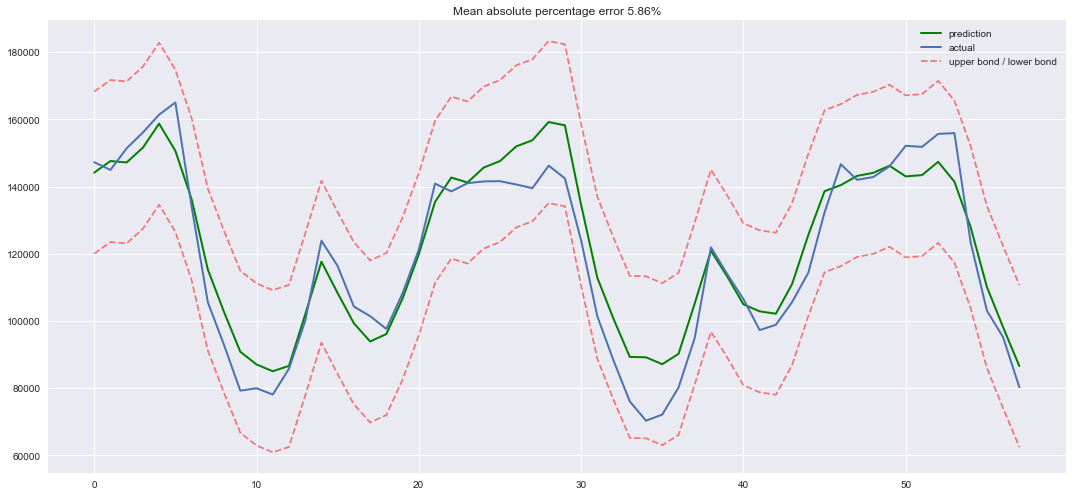

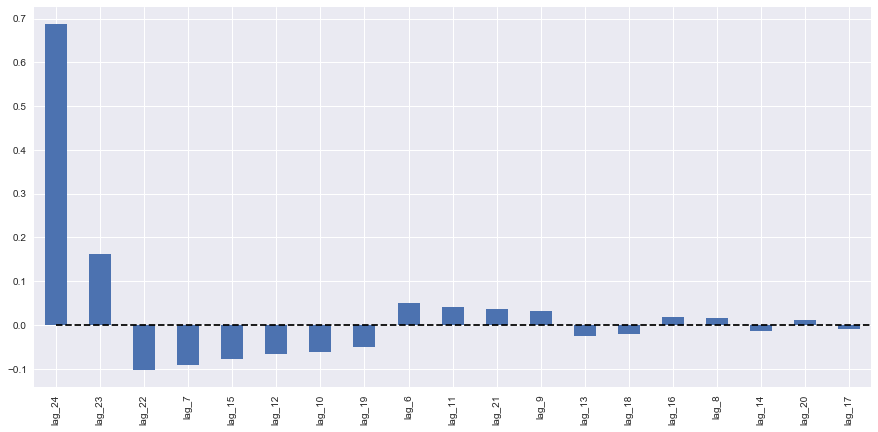

In [47]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

Что ж, всего лишь простыми лагами удалось построить модель, которая не сильно уступает по качеству SARIMA модели. Пока что в модели есть достаточно много мусорных факторов, но отбором займемся чуть позже, а пока продолжим придумывать признаки!

Добавим в датасет час, день недели и выходной в качестве категориальных переменных. Для этого переводим имеющийся в датафрейме индекс в формат `datetime`, и извлекаем из него `hour` и `weekday`.

In [48]:
data.index = data.index.to_datetime()
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
data.tail()

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,...,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,hour,weekday,is_weekend
Time,,,,,,,,,,,,,,,,,,,,,
2017-09-21 19:00:00,155890,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,...,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0,19,3,0
2017-09-21 20:00:00,123395,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,...,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,20,3,0
2017-09-21 21:00:00,103080,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,...,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,21,3,0
2017-09-21 22:00:00,95155,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,...,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,22,3,0
2017-09-21 23:00:00,80285,151790.0,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,...,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,23,3,0


Можно визуализировать получившиеся признаки

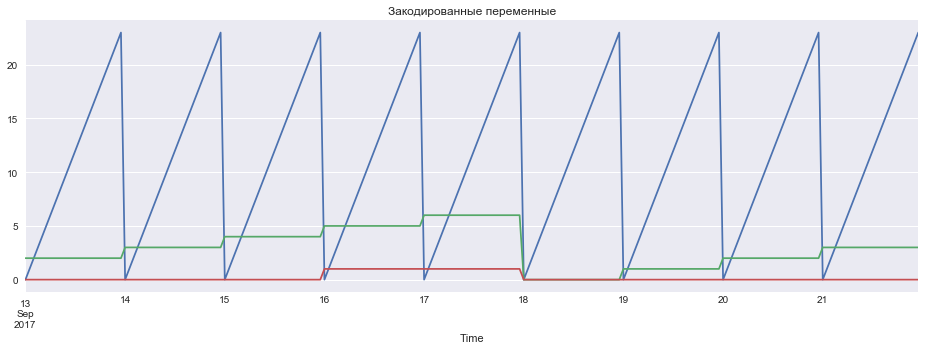

In [49]:
plt.figure(figsize=(16, 5))
plt.title("Закодированные переменные")
data.hour.plot()
data.weekday.plot()
data.is_weekend.plot()
plt.grid(True);

Так как теперь у нас данные в разном масштабе - десятки тысяч в лагах и единицы в категориях, имеет смысл привести всё к одному масштабу, чтобы можно было по-прежнему исследовать коэффициенты модели. Для этого воспользуемся `StandardScaler`

In [50]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

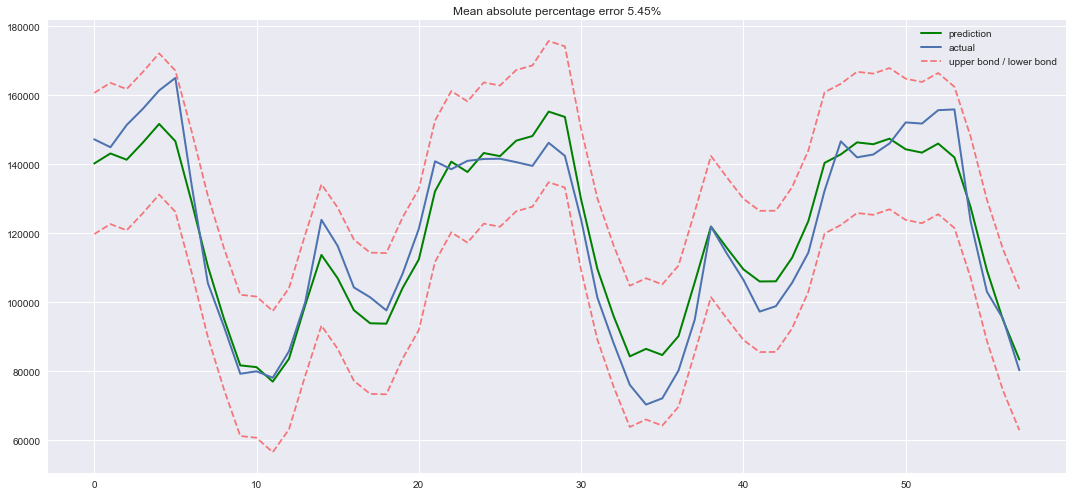

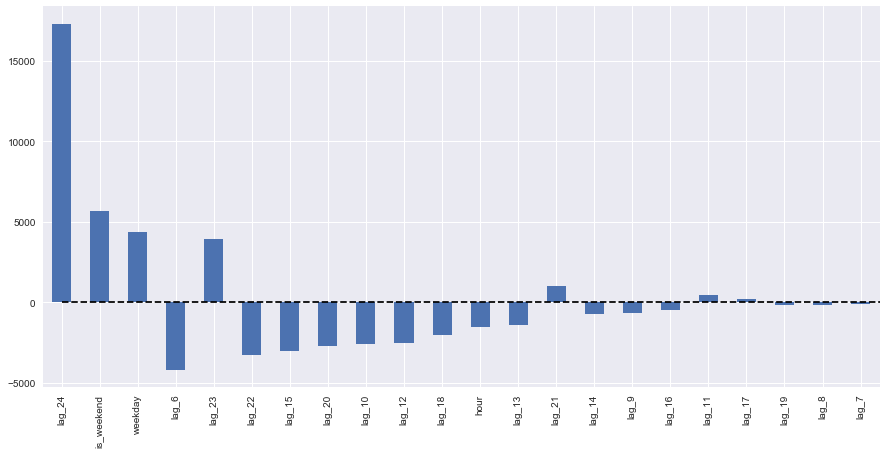

In [51]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# разбиваем датасет на тренировочную и тестовую часть, отложим 30% данных
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# учим регрессию
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

Ошибка на тесте еще немного уменьшилась, и по коэффициентам видно, что день недели и выходной - довольно неплохие признаки

А теперь, объединим все преобразования под одной функцией

In [52]:
def prepareData(series, lag_start, lag_end, test_size):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset
        
    """
    
    # Создадим копию исходного датафрейма, чтобы можно было выполнять различные преобразования
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # Добавляем лаги целевой переменной
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # Добавляем данные по часу, дню недели и выходным
    data.index = data.index.to_datetime()
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    # Делим на тренировочную и тестовую
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

In [53]:
X_train, X_test, y_train, y_test =\
prepareData(ads.Ads, lag_start=6, lag_end=25, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Boosting

Почему бы теперь не попробовать XGBoost
<img src="https://habrastorage.org/files/754/a9a/26e/754a9a26e59648de9fe2487241a27c43.jpg"/>

In [54]:
import sys
sys.path.append('/Users/dmitrys/xgboost/python-package/')
from xgboost import XGBRegressor 

/Users/dmitrys/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [55]:
xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

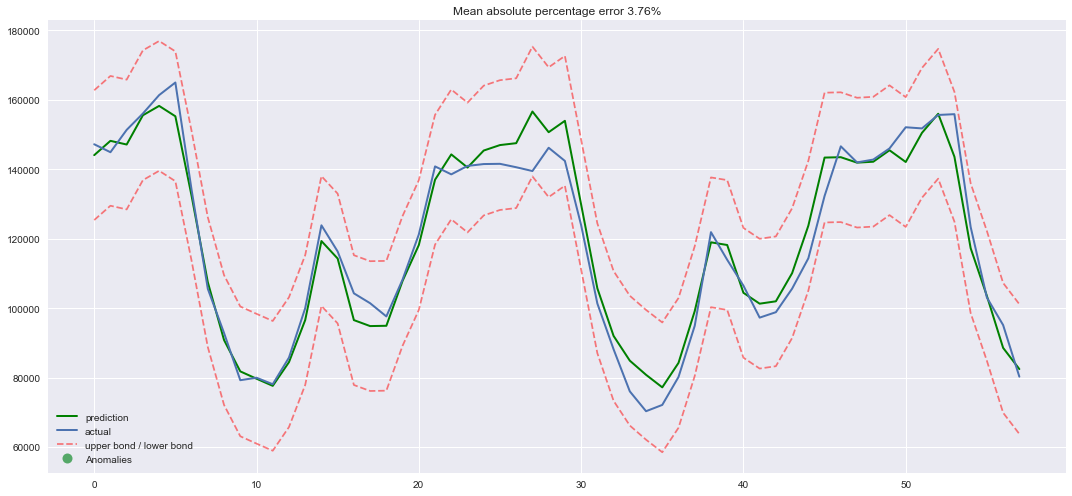

In [56]:
plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)

А вот и самая маленькая ошибка на отложенной выборке из всех опробованных, xgboost победил! 

Однако эта победа обманчива и не стоит первым делом при работе с временным рядом расчехлять xgboost. Дело в том, что модели с деревьями внутри, в отличие от линейных, довольно плохо справляются с трендами без помощи трюков с обработкой данных. В идеале - предварительно очистить данные от тренда, спрогнозировать тренд отдельно при помощи линейной модели, и отдельно - очищенный ряд, а потом сложить вместе предсказания. 

# 5) To Infinity and Beyond

## Facebook Prophet - автоматические прогнозы
https://github.com/facebook/prophet

[Предсказываем будущее с помощью библиотеки Facebook Prophet](https://habrahabr.ru/company/ods/blog/323730/)

Библиотека prophet позволяет быстро и достаточно качественно автоматически строить прогнозы временныз рядов. Подробно про теорию работы можно почитать в замечательной статьей по ссылке выше, а сейчас посмотрим на практике, как она работает

In [57]:
from fbprophet import Prophet

In [58]:
# задаем число предсказаний будущих значений
predictions = 60

# создаем специфический датасет, с определенными названиями столбцов
df = ads.reset_index()
df.columns = ['ds', 'y']
df.tail()

,ds,y
211,2017-09-21 19:00:00,155890
212,2017-09-21 20:00:00,123395
213,2017-09-21 21:00:00,103080
214,2017-09-21 22:00:00,95155
215,2017-09-21 23:00:00,80285


In [59]:
# откладываем часть данных для тестирования
train_df = df[:-predictions]

In [60]:
# обучаем модель, обязательно указывая тип сезонности, который хотим использовать
model = Prophet(weekly_seasonality=True)
model.fit(train_df)

# создаем еще один специфический датафрейм, который нужен для предсказаний
# здесь нужно указать частоту данных (по умолчанию - дни)
future = model.make_future_dataframe(periods=predictions, freq='H')
future.tail()

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


,ds
211,2017-09-21 19:00:00
212,2017-09-21 20:00:00
213,2017-09-21 21:00:00
214,2017-09-21 22:00:00
215,2017-09-21 23:00:00


In [61]:
# делаем предсказания 
forecast = model.predict(future)
forecast.tail()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,daily,daily_lower,daily_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yhat
211,2017-09-21 19:00:00,127788.152738,127786.687851,127789.642889,140610.961838,162819.990971,27772.779470,27772.779470,27772.779470,24225.435414,24225.435414,24225.435414,24225.435414,24225.435414,24225.435414,-3547.344056,-3547.344056,-3547.344056,152013.588151
212,2017-09-21 20:00:00,127821.399522,127819.907614,127822.935590,125380.800821,145718.541118,11516.514049,11516.514049,11516.514049,7920.829427,7920.829427,7920.829427,7920.829427,7920.829427,7920.829427,-3595.684622,-3595.684622,-3595.684622,135742.228948
213,2017-09-21 21:00:00,127854.646306,127853.112538,127856.221503,104668.730234,126107.021439,-9167.695441,-9167.695441,-9167.695441,-12784.175819,-12784.175819,-12784.175819,-12784.175819,-12784.175819,-12784.175819,-3616.480379,-3616.480379,-3616.480379,115070.470486
214,2017-09-21 22:00:00,127887.893090,127886.329003,127889.507473,86482.566023,106919.641759,-27833.328028,-27833.328028,-27833.328028,-31443.286306,-31443.286306,-31443.286306,-31443.286306,-31443.286306,-31443.286306,-3609.958278,-3609.958278,-3609.958278,96444.606784
215,2017-09-21 23:00:00,127921.139873,127919.561374,127922.766537,73256.210937,94366.568991,-40113.376920,-40113.376920,-40113.376920,-43689.911399,-43689.911399,-43689.911399,-43689.911399,-43689.911399,-43689.911399,-3576.534479,-3576.534479,-3576.534479,84231.228474


Mean absolute percentage error 9.25%


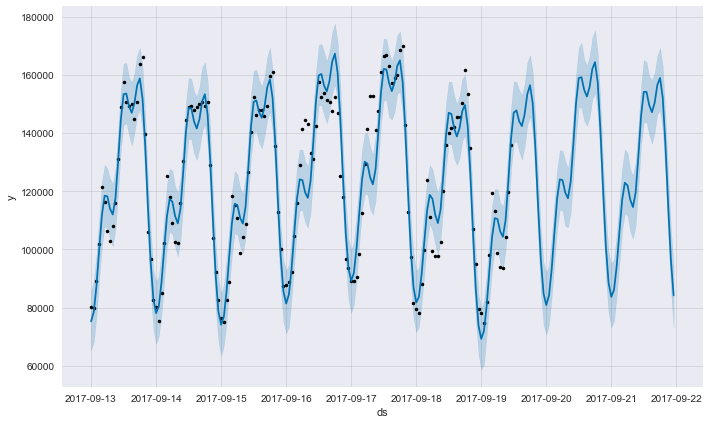

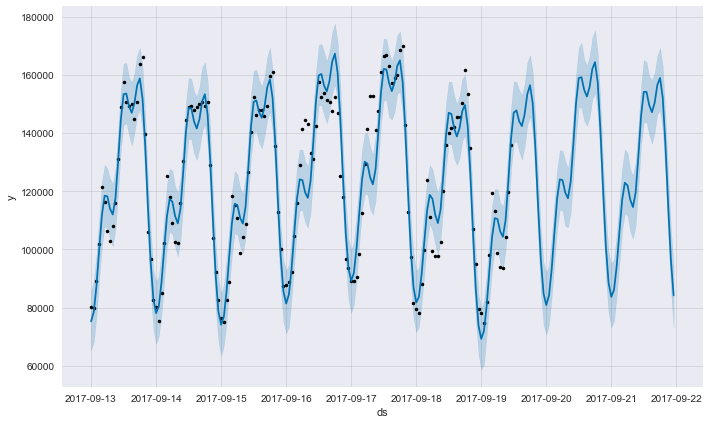

In [62]:
# а теперь рисуем картинки
error = mean_absolute_percentage_error(df[-predictions:]['y'], forecast[-predictions:]['yhat'])
print("Mean absolute percentage error {0:.2f}%".format(error))
model.plot(forecast)

Также можно посмотреть на декомпозицию исходного ряда на составляющие

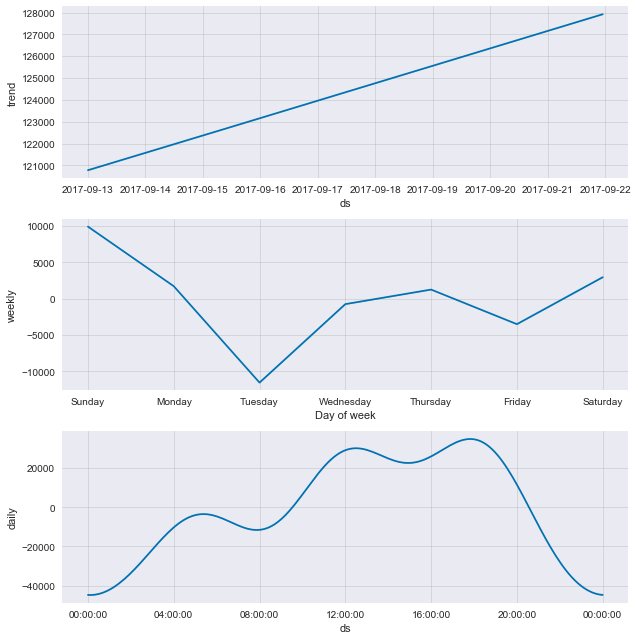

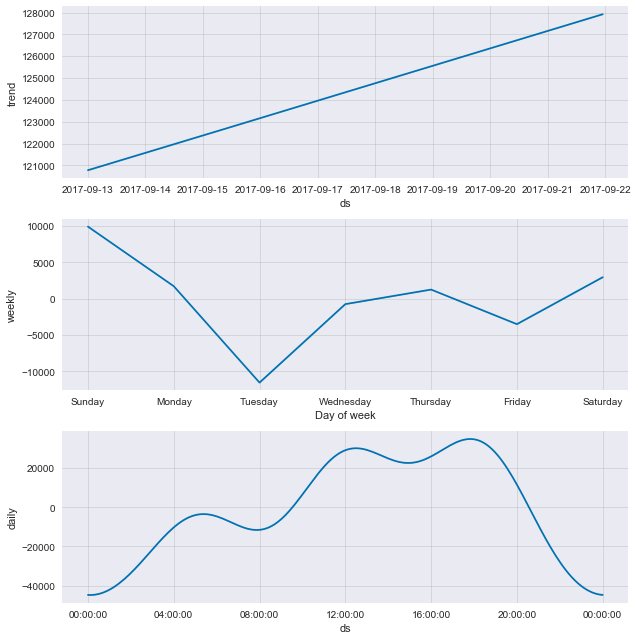

In [63]:
model.plot_components(forecast)